# Iterative Binary Classification with Active Learning: 

* This notebook implements an iterative approach to binary classification, leveraging active learning principles.

 * Starting with a mixed dataset containing positive samples and unlabeled data, the algorithm iteratvely:
    * trains a classifier, 
    * identifies samples likely to belong to the positive class using outlier analysis,
    * updates labels,
* Stop conditions based on model convergence, iteration limits, and classifier confidence ensure efficient and effective learning. 

Various classifiers and outlier detection techniques are explored, with continuous validation to ensure robustness and generalization. This framework facilitates the construction of a reliable binary classifier while managing imbalanced data and computational resources."

# imports

In [441]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.utils import resample

import pandas as pd
import mlflow 


# Read_Data

In [442]:
df = pd.read_csv(r'C:\Users\diego.kieckbusch\Desktop\MVPs\MonitorInvestimento\data\uds\insvestimentos_uds.csv', sep='|', header=0, index_col='id')
df.shape

(3526, 47)

In [443]:
df = df.dropna(subset=['titulo'])
df.shape

(3373, 47)

In [444]:
df['target'] = df['Verificada'].map(lambda x: 1 if x=='Sim' else 0)


In [445]:
df['target'].value_counts()

target
0    3087
1     286
Name: count, dtype: int64

# Create first trainining set

In [446]:
import numpy as np
import matplotlib.pyplot as plt

def save_hist(data1, data2, name='0'):
    # Define the number of bins for the histogram
    num_bins = 50

    # Calculate bin edges based on the probabilities
    bin_edges = np.linspace(0, 1, num_bins + 1)

    # Compute histograms for both variables
    prob_hist, _ = np.histogram(data1, bins=bin_edges)
    other_hist, _ = np.histogram(data2, bins=bin_edges)

    # Calculate proportions
    total_samples = len(data1) +len(data2)
    prob_proportions = prob_hist / len(data1)
    other_proportions = other_hist / len(data2)

    # Plot stacked histogram with proportion
    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], prob_proportions, width=np.diff(bin_edges), color='skyblue', alpha=0.7, label='Probabilities')
    plt.bar(bin_edges[:-1], other_proportions, width=np.diff(bin_edges), color='orange', alpha=0.7, label='Other Column', bottom=prob_proportions)
    plt.xlabel('Value')
    plt.ylabel('Proportion')
    plt.title('Stacked Histogram of Probabilities and Other Column (Proportion)')
    plt.legend()
    plt.grid(True)
    plt.savefig(r'C:\Users\diego.kieckbusch\Desktop\MVPs\MonitorInvestimento\histograms\\' + name + 'histogram.png')
    plt.show()

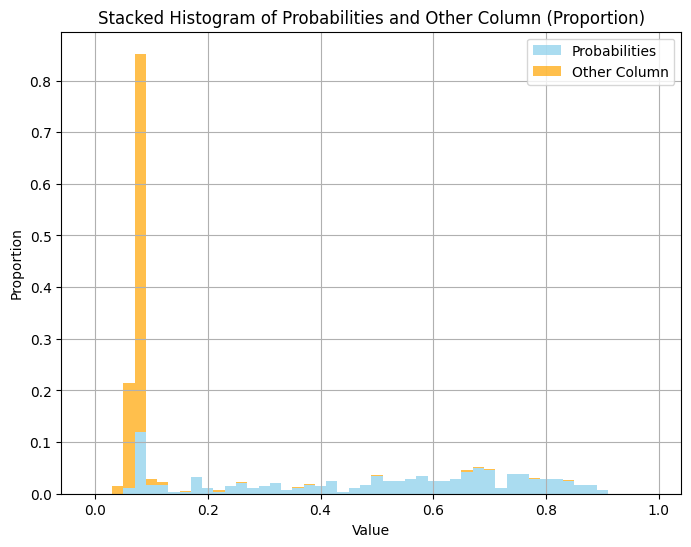

total novas: 98
removidas:  2989


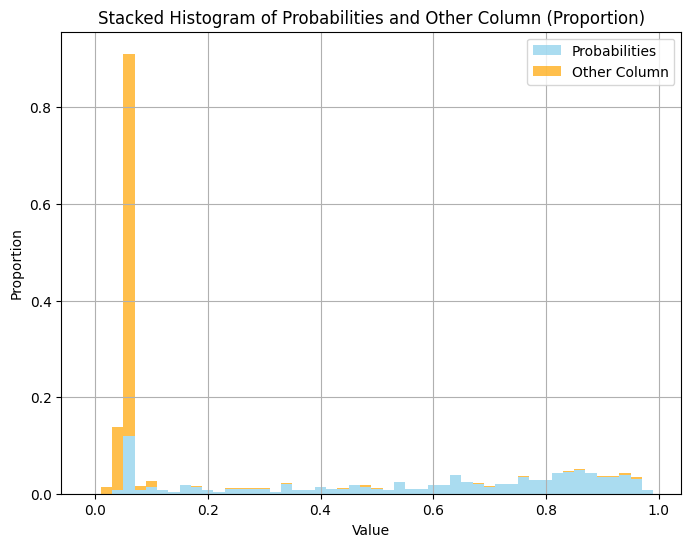

total novas: 25
removidas:  2964


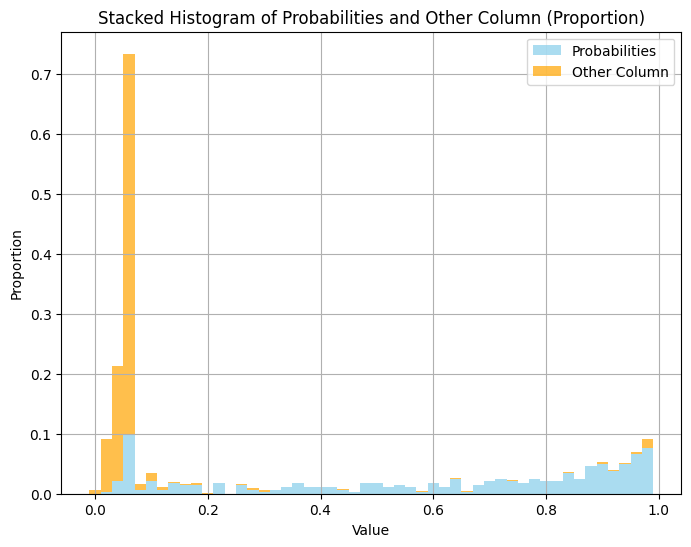

total novas: 31
removidas:  2933


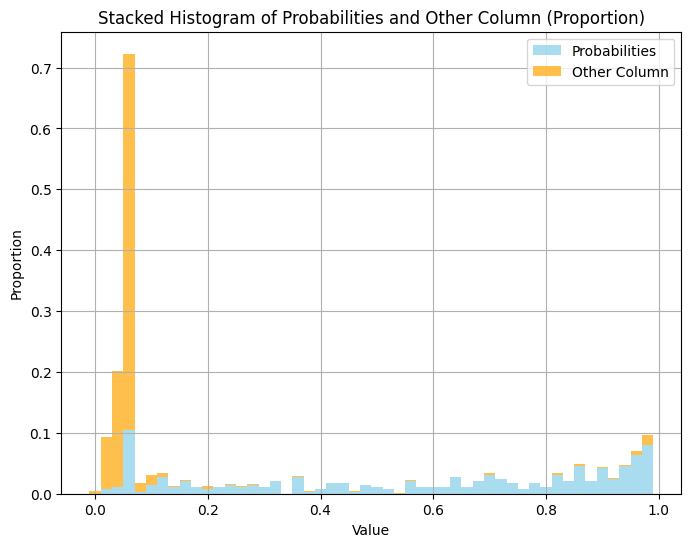

total novas: 35
removidas:  2900


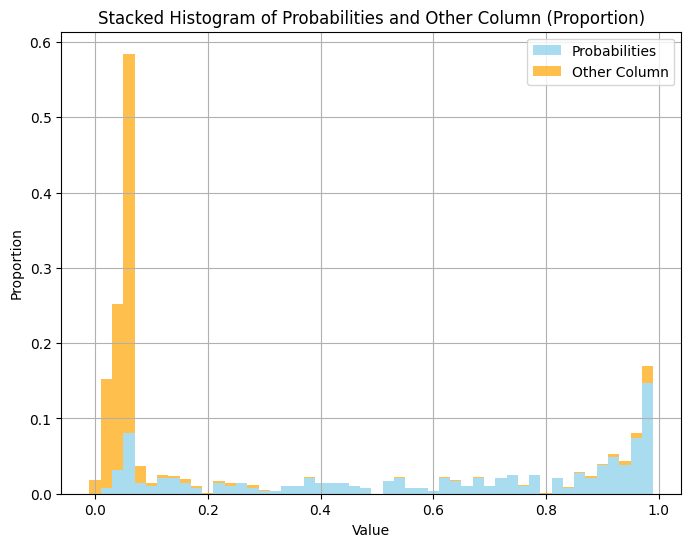

total novas: 52
removidas:  2850


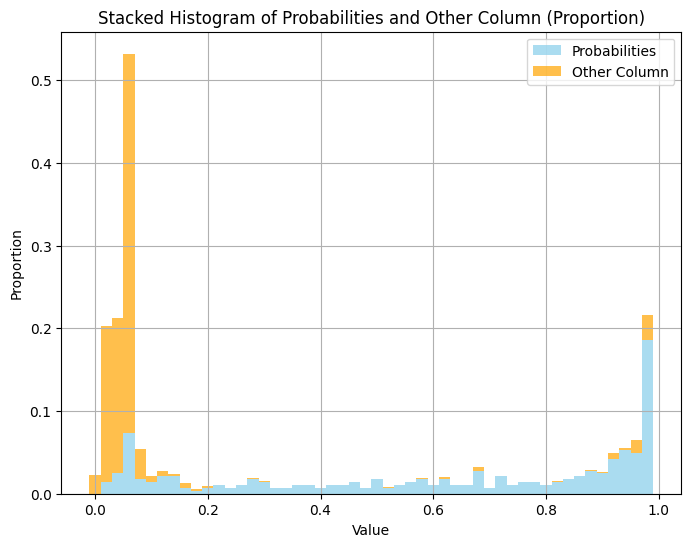

total novas: 19
removidas:  2831


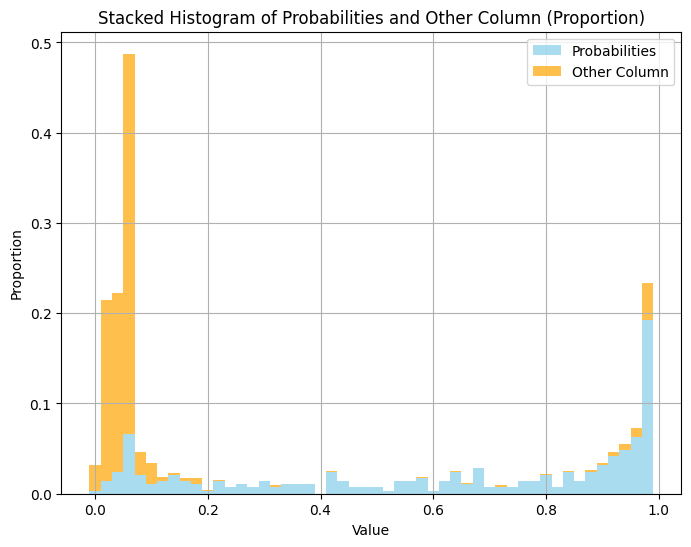

total novas: 31
removidas:  2806


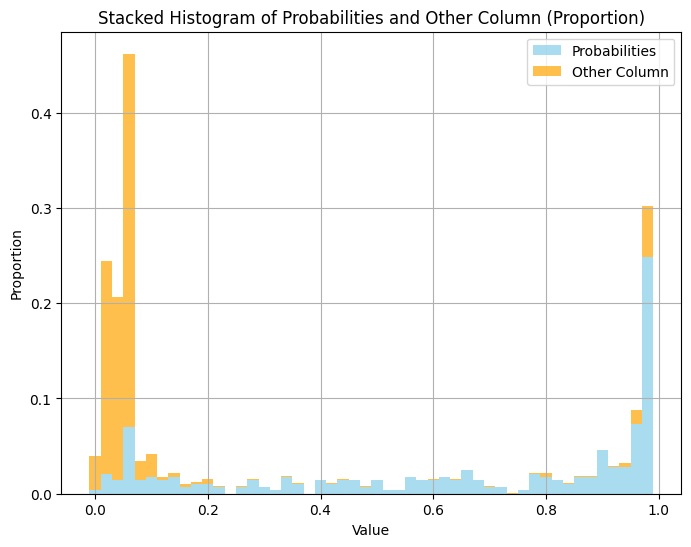

total novas: 26
removidas:  2782


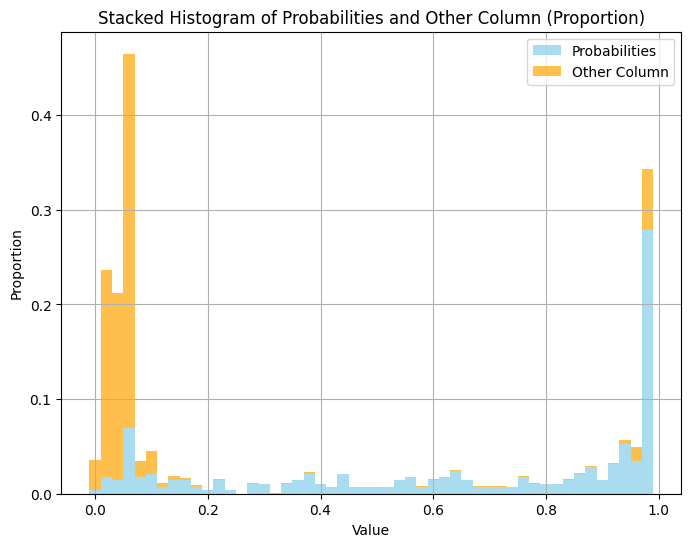

total novas: 9
removidas:  2773


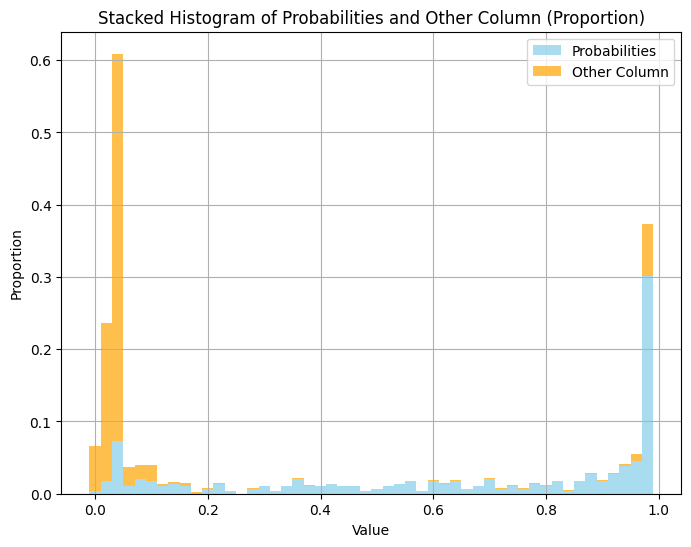

total novas: 3
removidas:  2770


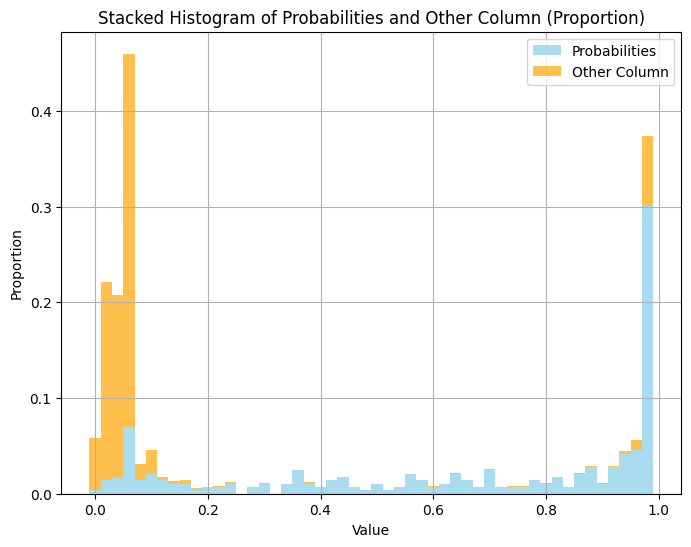

total novas: 4
removidas:  2766


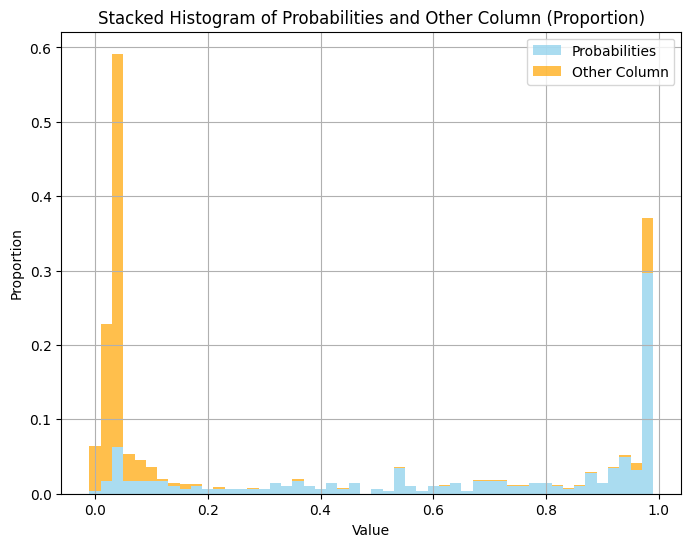

total novas: 3
removidas:  2763


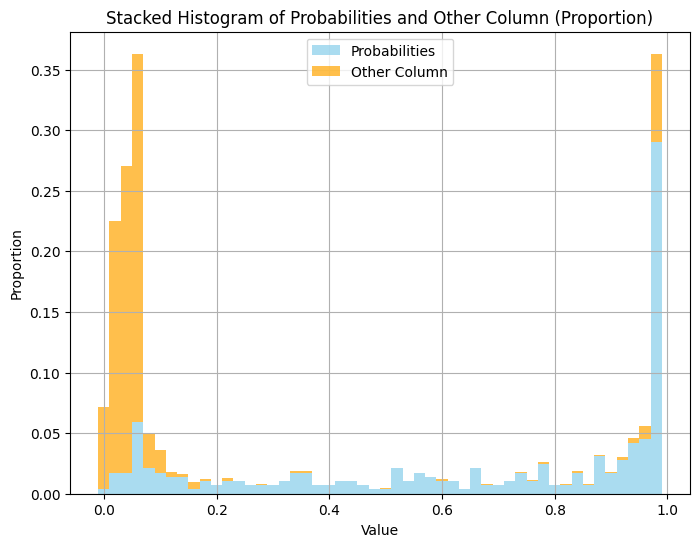

total novas: 6
removidas:  2757


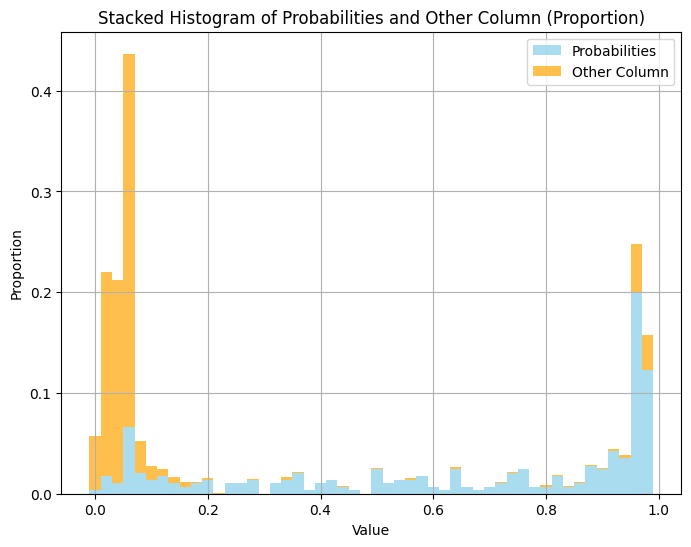

total novas: 2
removidas:  2755


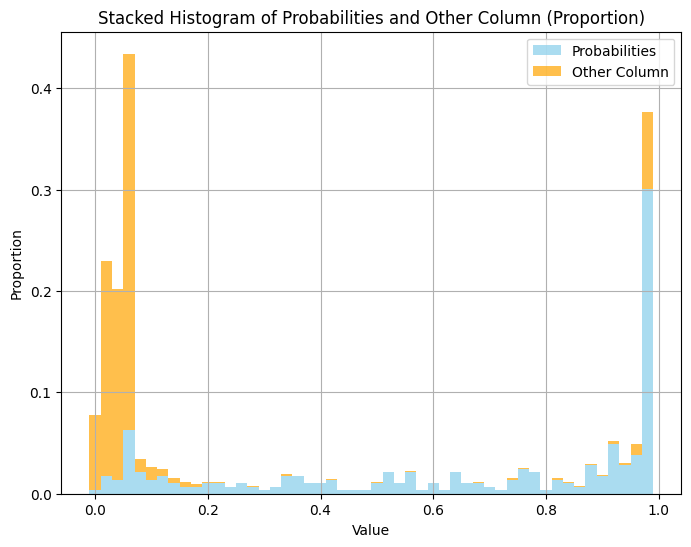

total novas: 2
removidas:  2753


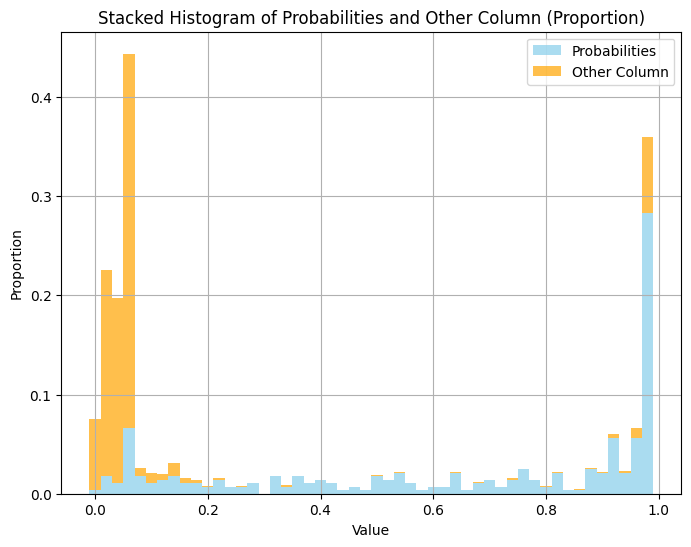

total novas: 5
removidas:  2748


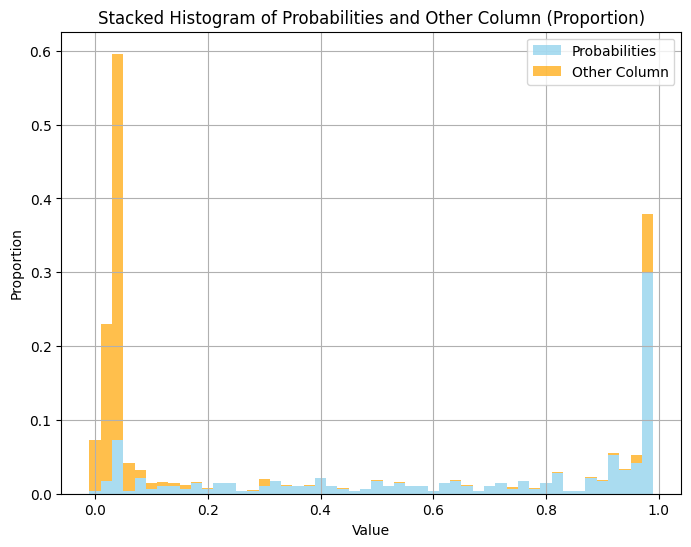

total novas: 37
removidas:  2711


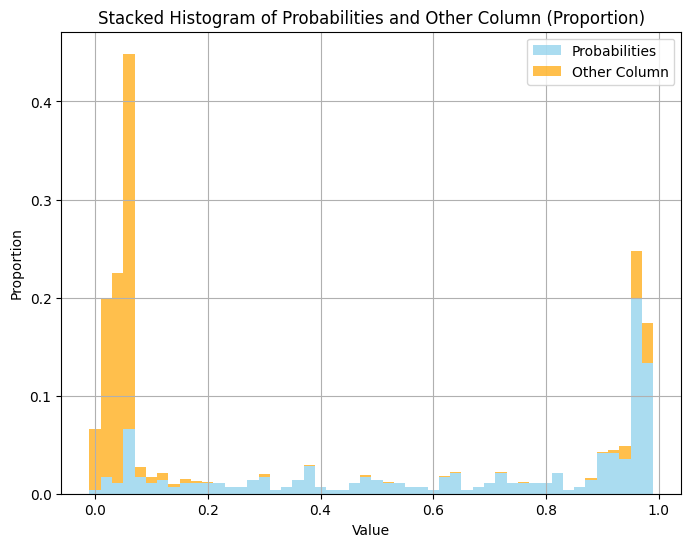

total novas: 4
removidas:  2707


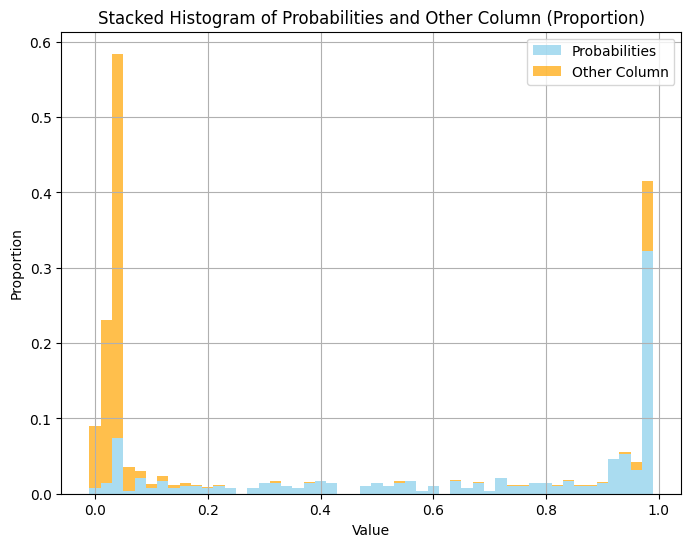

total novas: 3
removidas:  2704


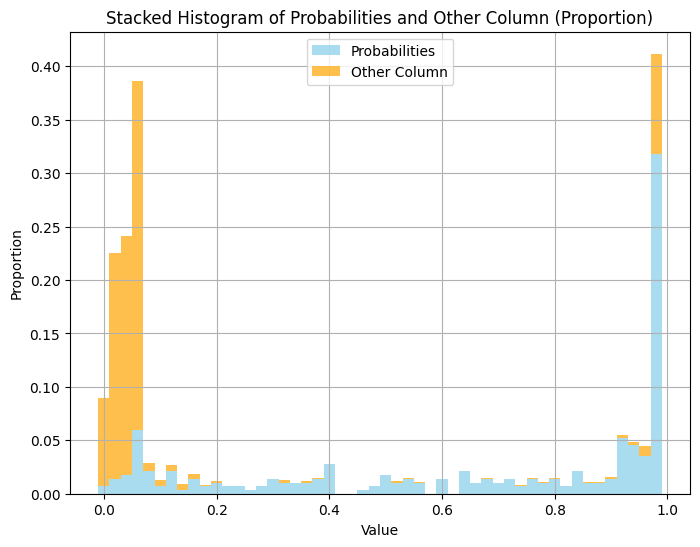

total novas: 0
removidas:  2704


In [447]:
'''
First iteration: train model on pseudo_label

'''
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def train_model(X_train, y_train):
    # Create a pipeline with CountVectorizer followed by LogisticRegression
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),  # Convert text to a matrix of token counts
        ('classifier', SVC(probability=True))  # Logistic Regression classifier
    ])


    # Train the pipeline
    pipeline.fit(X_train, y_train)
    return pipeline

def get_train(df):
    train_ = df.drop_duplicates(subset=['titulo'])
    X_train = train_['titulo']
    y_train = train_['target']
    return X_train, y_train

#get training data
X_train, y_train = get_train(df)
limiar = y_train.mean() 

# Predict using the pipeline on the entire dataset
pipeline = train_model(X_train, y_train)
probabilities=pipeline.predict_proba(df.loc[:,'titulo'])[:,1]
df.loc[:, 'proba']= probabilities
#generate histogram of prob distribution
data1 =df[df['Verificada']=='Sim']['proba']
data2 =df[df['Verificada']!='Sim']['proba']
save_hist(data1, data2)

condition = (df['Verificada']!='Sim') & (df['target']==0) & (df['proba']>=limiar)
condition_fail = (df['Verificada']!='Sim') & (df['proba']< limiar)
print('total novas:', condition.sum())
print('removidas: ', condition_fail.sum())

#count updated labels
new_samples = df.loc[condition].shape[0]
# update labels for mixed data
df.loc[condition, ['target']] = 1
df.loc[condition_fail, ['target']] = 0
#save new data for log
df.loc[condition].to_csv(str(i) + 'new_class.csv', sep='|', header=True)

#generate new train data
X_train, y_train = get_train(df)


i=1
while (new_samples>0 and i<40):
    limiar = y_train.mean()

    pipeline = train_model(X_train, y_train)
    probabilities=pipeline.predict_proba(df.loc[:,'titulo'])[:,1]
    df.loc[:, 'proba']=probabilities
    
    #generate histogram of prob distribution
    data1 =df[df['Verificada']=='Sim']['proba']
    data2 =df[df['Verificada']!='Sim']['proba']
    save_hist(data1, data2, str(i))
    #count updated labels
    condition = (df['Verificada']!='Sim') & (df['target']==0) & (df['proba']>limiar)
    condition_fail = (df['Verificada']!='Sim') & (df['proba']<limiar)
    print('total novas:', condition.sum())
    print('removidas: ', condition_fail.sum())
    
    new_samples = df.loc[condition].shape[0]
    # update labels for mixed data
    df.loc[condition, ['target']] = 1
    df.loc[condition_fail, ['target']] = 0
    #save new data for log
    df.loc[condition].to_csv(str(i) +' _new_class_0.csv', sep='|', header=True)
    i=i+1
    #generate new train data
    #get training data
    X_train, y_train = get_train(df)


In [459]:
df['Verificada'].value_counts()

Verificada
Não    3081
Sim     286
Name: count, dtype: int64

In [461]:
df.drop_duplicates(subset=['titulo'])['target'].value_counts()

target
0    1504
1     433
Name: count, dtype: int64

In [462]:
df.drop_duplicates(subset=['titulo']).loc[df['target']==1, ['titulo', 'Verificada', 'target', 'proba']]

,titulo,Verificada,target,proba
id,,,,
87852490.0,Sigma Lithium obtém linha de crédito junto ao ...,Sim,1,0.533022
87864547.0,R$ 1 Bilhão em nova indústria de motores no Br...,Não,1,0.963370
87900923.0,Aporte de R$ 178 Milhões,Não,1,0.980265
87906429.0,Fruki investe R$ 178 milhões numa planta indus...,Não,1,0.982658
83054287.0,"Stellantis, proprietária da Citroën, anuncia i...",Sim,1,0.951342
...,...,...,...,...
84231997.0,Suspensys vai investir em nova fábrica em Mogi...,Sim,1,0.982645
84233128.0,Investimento milionário avança na Grande Flori...,Sim,1,0.349239
84251618.0,Arauco anuncia 400 vagas de emprego em nova fá...,Sim,1,0.789867


In [451]:
df.columns

Index(['Unnamed: 0', 'titulo', 'autor', 'resumo', 'texto', 'data_publicacao',
       'data_captura', 'data_cadastro', 'data_ultimaalteracao', 'veiculo',
       'editoria', 'pagina', 'duracao', 'valoracao', 'audiencia', 'alcance',
       'verificada', 'similares', 'campos_personalizados', 'url_original',
       'urls_monitoring', 'associacoes', 'arquivos', 'id_veiculo',
       'nome_veiculo', 'tipo', 'tier', 'pais_veiculo', 'estado_veiculo',
       'cidade_veiculo', 'projeto', 'projeto_id', 'campos',
       'UF do Investimento', 'Objetivo do Investimento',
       'Origem do Investimento', 'Setor do Investimento', 'CNAE DIV',
       'Moeda do Anúncio do Investimento', '0', 'projeto.1', 'projeto_id.1',
       'palavra', 'assunto', 'avaliacao', 'motivacao', 'Verificada', 'target',
       'proba'],
      dtype='object')

In [452]:
import ast
df['similares'] = df['similares'].map(lambda x:ast.literal_eval(x))

In [453]:

noticias_tratadas = set()
for row in df[df['Verificada']=='Sim']['similares']:
    for x in row:
        noticias_tratadas.add(x)

In [463]:
id_classificadas = df.drop_duplicates(subset=['titulo'])[(df['target']==1)& (df['Verificada']!='Sim')].index

C:\Users\diego.kieckbusch\AppData\Local\Temp\ipykernel_25576\2468972169.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  id_classificadas = df.drop_duplicates(subset=['titulo'])[(df['target']==1)& (df['Verificada']!='Sim')].index


In [464]:
sita = []
for i in id_classificadas.map(lambda x:str(x)[:-2]):
    sita.append(i in noticias_tratadas)

In [465]:
sum(sita)

40

In [466]:
len(sita)

187